In [1]:
import pandas as pd

# Read the txt file (assuming it's space or tab-separated)
df = pd.read_csv("/kaggle/input/us-101/dataUs-101_20250220.csv")
df

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,...,D_Zone,Int_ID,Section_ID,Direction,Movement,Preceding,Following,Space_Headway,Time_Headway,Location
0,656,4433,15,1118936123200,52.101,1596.844,6452488.528,1874284.138,15.0,7.0,...,208,0,5,3,1,0,547,0.00,0.00,lankershim
1,656,4434,15,1118936123300,51.484,1596.786,6452487.353,1874285.857,15.0,7.0,...,208,0,5,3,1,0,547,0.00,0.00,lankershim
2,656,4437,15,1118936123600,49.641,1598.462,6452483.839,1874290.970,15.0,7.0,...,208,0,5,2,1,0,547,0.00,0.00,lankershim
3,656,4439,15,1118936123800,48.591,1601.666,6452481.746,1874294.259,15.0,7.0,...,208,0,5,2,1,0,547,0.00,0.00,lankershim
4,656,4429,15,1118936122800,54.586,1596.844,6452493.257,1874277.243,15.0,7.0,...,208,4,0,3,3,0,0,0.00,0.00,lankershim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607314,1325,8022,2306,1118937502100,31.815,128.311,6451988.640,1872911.968,12.9,6.3,...,208,0,2,2,1,1421,0,196.60,7.70,lankershim
1607315,1325,8414,2306,1118937541300,39.773,313.843,6452069.023,1873077.489,12.9,6.3,...,208,0,2,2,1,1421,1430,21.54,9999.99,lankershim
1607316,1325,9103,2306,1118937610200,25.587,554.585,6452171.737,1873293.827,12.9,6.3,...,208,0,3,2,1,1421,1430,37.03,3.38,lankershim
1607317,1325,9590,2306,1118937658900,63.363,1509.828,6452497.930,1874193.668,12.9,6.3,...,208,4,0,2,1,1421,1430,49.80,1.27,lankershim


In [2]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'O_Zone', 'D_Zone', 'Int_ID', 'Section_ID',
       'Direction', 'Movement', 'Preceding', 'Following', 'Space_Headway',
       'Time_Headway', 'Location'],
      dtype='object')

In [3]:
df.dtypes

Vehicle_ID         int64
Frame_ID           int64
Total_Frames       int64
Global_Time        int64
Local_X          float64
Local_Y          float64
Global_X         float64
Global_Y         float64
v_length         float64
v_Width          float64
v_Class            int64
v_Vel            float64
v_Acc            float64
Lane_ID            int64
O_Zone             int64
D_Zone             int64
Int_ID             int64
Section_ID         int64
Direction          int64
Movement           int64
Preceding          int64
Following          int64
Space_Headway    float64
Time_Headway     float64
Location          object
dtype: object

**Sequential graph Construction**

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

# Load the dataset
data = pd.read_csv("/kaggle/input/us-101/dataUs-101_20250220.csv")
# data = pd.read_csv("path_of_dataset")
def create_graph(timestep_data, ego_vehicle_id, threshold_distance, max_nodes):
    G = nx.Graph()
    ego_vehicle = timestep_data[timestep_data['Vehicle_ID'] == ego_vehicle_id]
    if not ego_vehicle.empty:
        ego_x = ego_vehicle['Local_X'].values[0]
        ego_y = ego_vehicle['Local_Y'].values[0]
        
        # Add the ego vehicle as a node
        G.add_node(ego_vehicle_id, 
                   features={
                       'Local_X': ego_x,
                       'Local_Y': ego_y,
                       'v_Vel': ego_vehicle['v_Vel'].values[0],
                       'v_Acc': ego_vehicle['v_Acc'].values[0],
                       'Lane_ID': ego_vehicle['Lane_ID'].values[0]
                   })
        
        node_count = 0  # Start with the ego vehicle
        
        # Add neighboring vehicles as nodes and edges
        for _, vehicle in timestep_data.iterrows():
            if node_count > max_nodes:
                break
            if vehicle['Vehicle_ID'] != ego_vehicle_id:
                distance = np.sqrt((ego_x - vehicle['Local_X'])**2 + (ego_y - vehicle['Local_Y'])**2)
                # print("Distance:", distance)
                if distance < threshold_distance:
                    G.add_node(vehicle['Vehicle_ID'], 
                               features={
                                   'Local_X': vehicle['Local_X'],
                                   'Local_Y': vehicle['Local_Y'],
                                   'v_Vel': vehicle['v_Vel'],
                                   'v_Acc': vehicle['v_Acc'],
                                   'Lane_ID': vehicle['Lane_ID']
                               })
                    G.add_edge(ego_vehicle_id, vehicle['Vehicle_ID']) #, distance=distance)
                    node_count += 1
    
    # Add null nodes if the number of nodes is less than max_nodes
    while len(G.nodes()) < max_nodes:
        null_node_id = f'null_{len(G.nodes())}'
        G.add_node(null_node_id, 
                   features={
                       'Local_X': 0,
                       'Local_Y': 0,
                       'v_Vel': 0,
                       'v_Acc': 0,
                       'Lane_ID': 0
                   })
        G.add_edge(ego_vehicle_id, null_node_id) #, distance=0)
        
    return G

def extract_features_and_adjacency(data, ego_vehicle_id, threshold_distance, max_nodes):
    features = []
    adjacency_matrices = []
    future_locations = []
    ego_vehicle_df = data[data['Vehicle_ID'] == ego_vehicle_id]
    direction = ego_vehicle_df["Direction"].unique()
    for direc in direction:
        ego_vehicle_df = ego_vehicle_df[ego_vehicle_df["Direction"] == direc]
        ego_vehicle_df.sort_values(by='Global_Time', ascending=True)
        graph_count = 0  # Initialize graph count
        future_location_count = 0
        for frame in ego_vehicle_df["Frame_ID"]:
            new_df = data[(data["Frame_ID"] == frame) & (data["Direction"] == direc)]
            if graph_count < 5:
                G = create_graph(new_df, ego_vehicle_id, threshold_distance, max_nodes)
                if G.number_of_nodes() > 0:
                    node_features = nx.get_node_attributes(G, 'features')
                    # print(node_features)
                    feature_matrix = np.zeros((max_nodes,5)) 
                    for i, node in enumerate(G.nodes()):
                        if i < max_nodes:
                            feature_matrix[i] = list(node_features[node].values())
                    features.append(feature_matrix)
                    adjacency_matrix = nx.adjacency_matrix(G).todense()
                    adjacency_matrices.append(adjacency_matrix)
                    graph_count += 1  # Increment graph count
            if graph_count >= 5 and future_location_count <= 3:
                ego_vehicle = new_df[new_df['Vehicle_ID'] == ego_vehicle_id]
                if not ego_vehicle.empty:
                    ego_x = ego_vehicle['Local_X'].values[0]
                    ego_y = ego_vehicle['Local_Y'].values[0]
                    future_locations.append((ego_x, ego_y))
                    future_location_count += 1
    return features, adjacency_matrices, future_locations


def create_graph_sequences_for_all_vehicles(data, threshold_distance, max_nodes):
    all_graph_sequences = []
    unique_vehicle_ids = data['Vehicle_ID'].unique()
    for ego_vehicle_id in unique_vehicle_ids:
        features, adjacency_matrices, future_locations = extract_features_and_adjacency(data, ego_vehicle_id, threshold_distance, max_nodes)
        all_graph_sequences.append((features, adjacency_matrices, future_locations))
    return all_graph_sequences

# Set a threshold distance for defining edges
threshold_distance = 100.0  # Example value, adjust as needed

# Set the maximum number of nodes (vehicles) to consider in each graph
max_nodes = 5  # Example value, adjust based on your dataset

# Generate graph sequences for all vehicles
graph_sequences = create_graph_sequences_for_all_vehicles(data, threshold_distance, max_nodes)

print("Graph sequence dataset created successfully.")
# Save the graph sequences to a file
with open('graph_sequences.pkl', 'wb') as f:
    pickle.dump(graph_sequences, f)

print("Graph sequences saved successfully.")

# Load the graph sequences from a file
with open('graph_sequences.pkl', 'rb') as f:
    loaded_graph_sequences = pickle.load(f)

print("Graph sequences loaded successfully.")

Graph sequence dataset created successfully.
Graph sequences saved successfully.
Graph sequences loaded successfully.


In [6]:
import pickle
with open('/kaggle/working/graph_sequences.pkl', 'rb') as f:
    loaded_graph_sequences = pickle.load(f)


In [70]:
loaded_graph_sequences[97]

([array([[ 2.029700e+01,  1.607002e+03,  2.626000e+01,  1.522000e+01,
           2.000000e+00],
         [ 3.373400e+01,  1.554458e+03,  5.272000e+01,  9.220000e+00,
           2.000000e+00],
         [ 6.075300e+01,  1.521609e+03,  3.885000e+01, -5.600000e-01,
           4.000000e+00],
         [ 4.783700e+01,  1.610239e+03,  2.247000e+01,  0.000000e+00,
           4.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00]]),
  array([[  19.895, 1601.982,   24.4  ,    0.   ,    2.   ],
         [  35.914, 1543.394,   52.15 ,   11.48 ,    2.   ],
         [  61.748, 1513.192,   46.76 ,    0.   ,    4.   ],
         [  47.872, 1601.295,   22.47 ,    0.   ,    4.   ],
         [   0.   ,    0.   ,    0.   ,    0.   ,    0.   ]]),
  array([[ 1.039400e+01,  1.573451e+03,  2.222000e+01, -1.930000e+00,
           0.000000e+00],
         [ 2.608100e+01,  1.478939e+03,  0.000000e+00,  0.000000e+00,
           1.000000e+00],
         [ 5.663400

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [42]:
def visualize_graph_sequence(graph_feats, adj_mats, future_coords):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    num_timesteps = len(graph_feats)
    num_nodes = graph_feats[0].shape[0]
    
    fig, axes = plt.subplots(1, num_timesteps, figsize=(4 * num_timesteps, 4))
    
    if num_timesteps == 1:
        axes = [axes]

    for t in range(num_timesteps):
        G = nx.from_numpy_array(adj_mats[t], create_using=nx.DiGraph)
        pos = {}

        for node in range(num_nodes):
            x, y = graph_feats[t][node][0], graph_feats[t][node][1]
            pos[node] = (x, y)
        
        ax = axes[t]
        nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray')
        ax.set_title(f'Timestep {t}')
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
    
    plt.tight_layout()
    plt.show()

    # Plot trajectory of main vehicle
    past_coords = [frame[0][:2] for frame in graph_feats if not np.all(frame[0] == 0)]
    future_x, future_y = zip(*future_coords)

    past_x, past_y = zip(*past_coords)

    plt.figure(figsize=(6, 6))
    plt.plot(past_x, past_y, '-o', label='Past Trajectory')
    plt.plot(future_x, future_y, '-x', label='Future Trajectory', color='red')
    plt.legend()
    plt.title("Trajectory of Main Vehicle")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


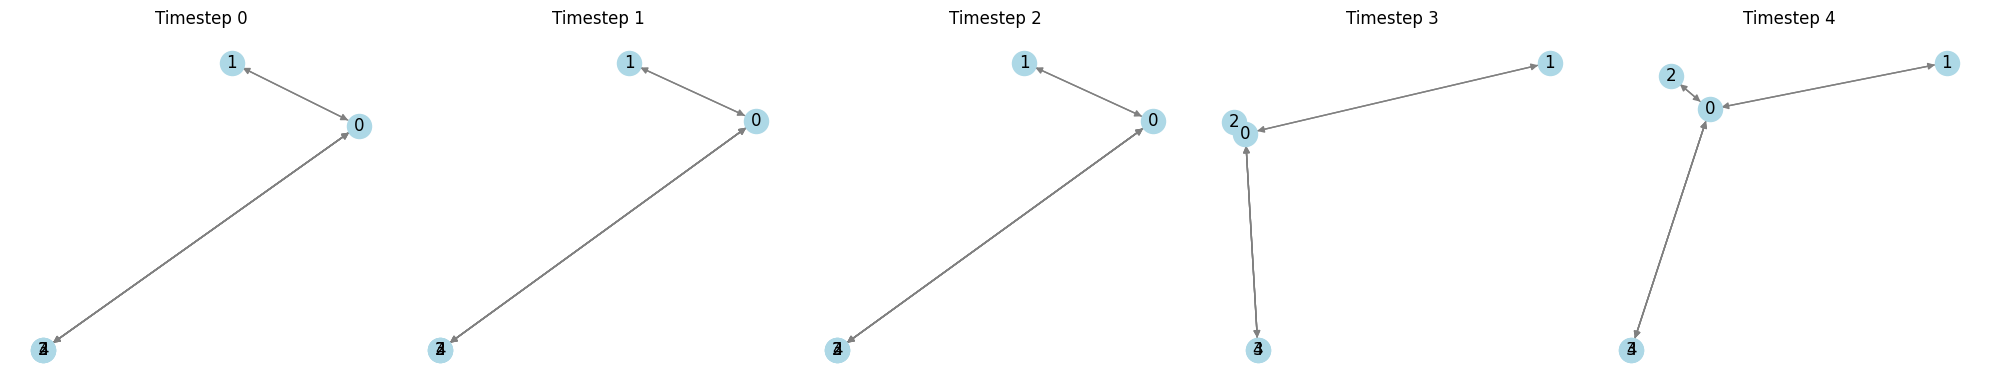

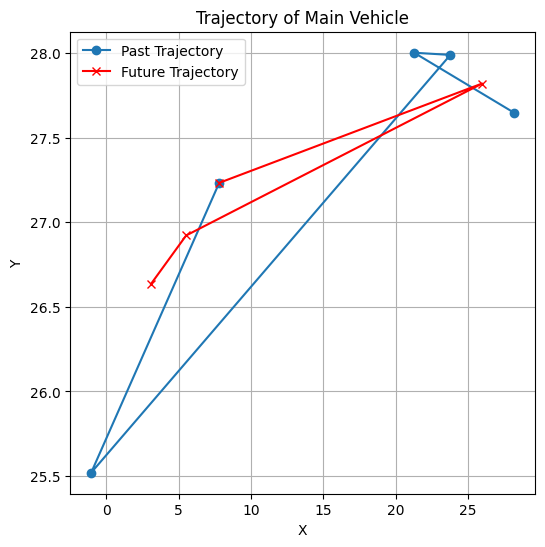

In [16]:
# sample = (graph_feats, adj_mats, future_coords)
sample = loaded_graph_sequences[1]
visualize_graph_sequence(*sample)


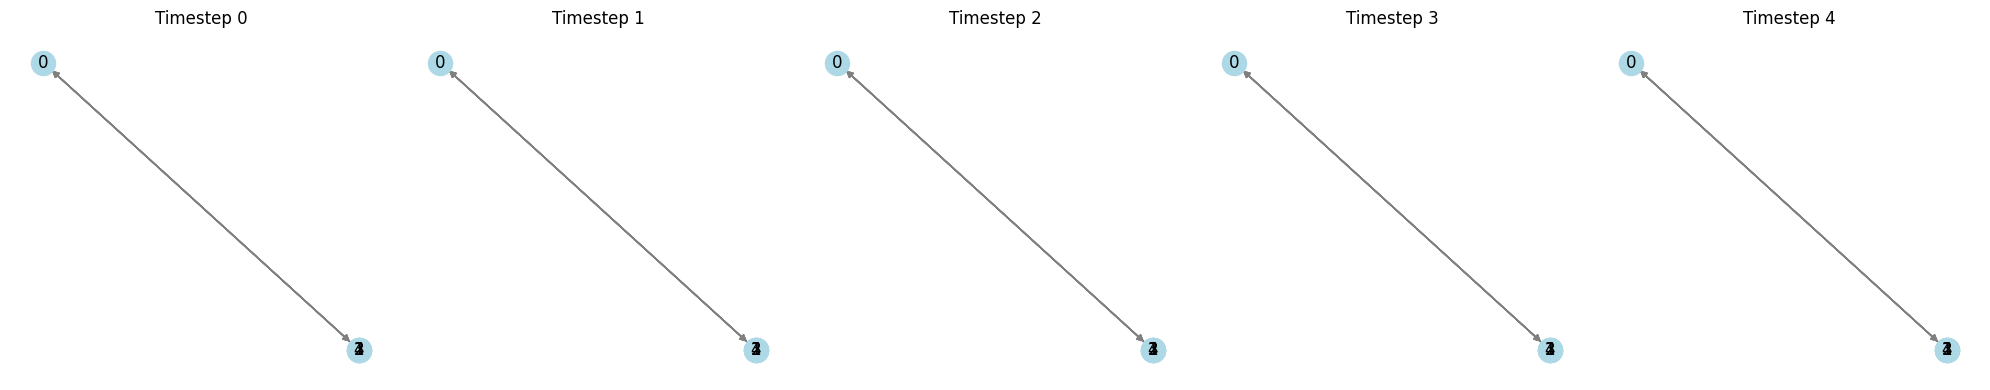

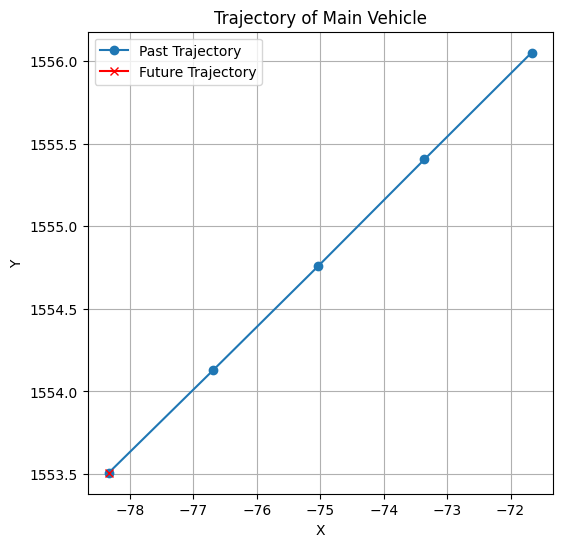

In [28]:
# sample = loaded_graph_sequences[1]
visualize_graph_sequence(*loaded_graph_sequences[12])

In [34]:
sample = loaded_graph_sequences[0]
graph_feats, _, future_coords = sample

past_coords = [frame[0][:2] for frame in graph_feats if not np.all(frame[0][:2] == 0)]
future_coords_filtered = [coord for coord in future_coords if not np.all(np.array(coord) == 0)]

print("Past Coords:")
print(past_coords)

print("Future Coords:")
print(future_coords_filtered)


Past Coords:
[array([  52.101, 1596.844]), array([  51.484, 1596.786]), array([  54.586, 1596.844]), array([  55.212, 1596.844]), array([  53.34 , 1596.844])]
Future Coords:
[(53.34, 1596.844), (52.72, 1596.844), (50.863, 1596.971), (50.241, 1597.513)]


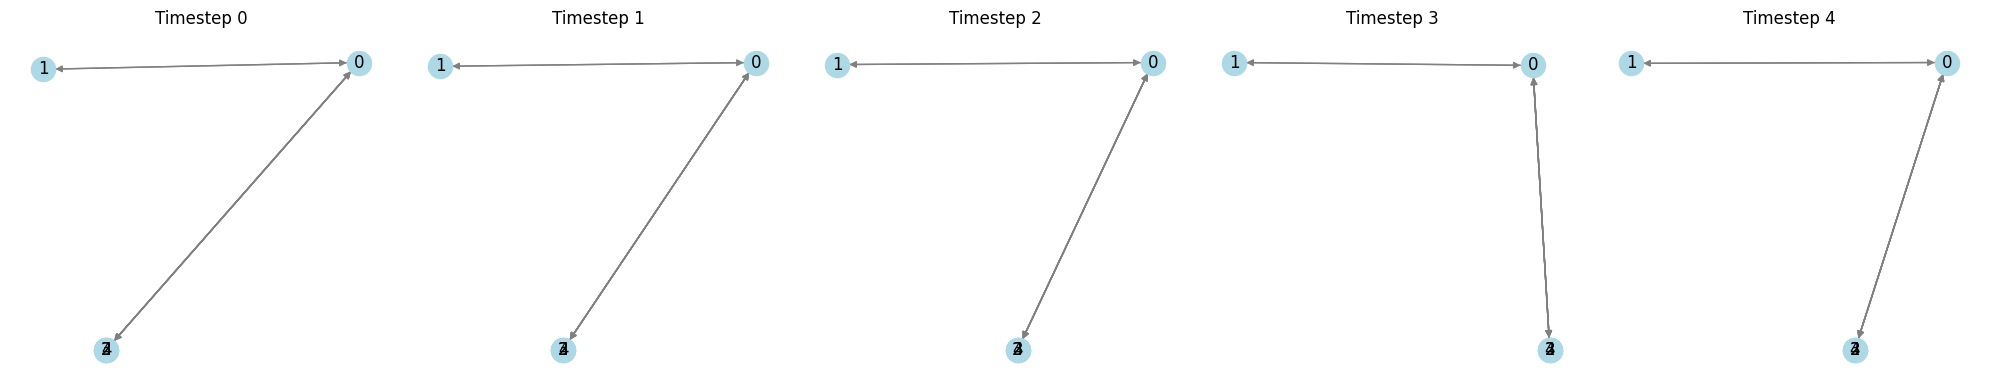

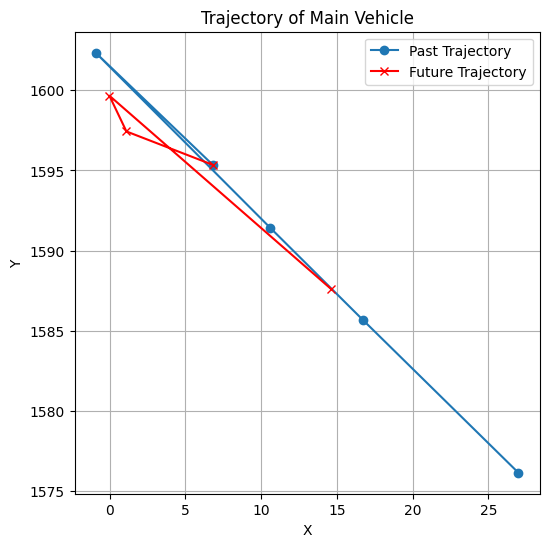

In [49]:
visualize_graph_sequence(*loaded_graph_sequences[45])

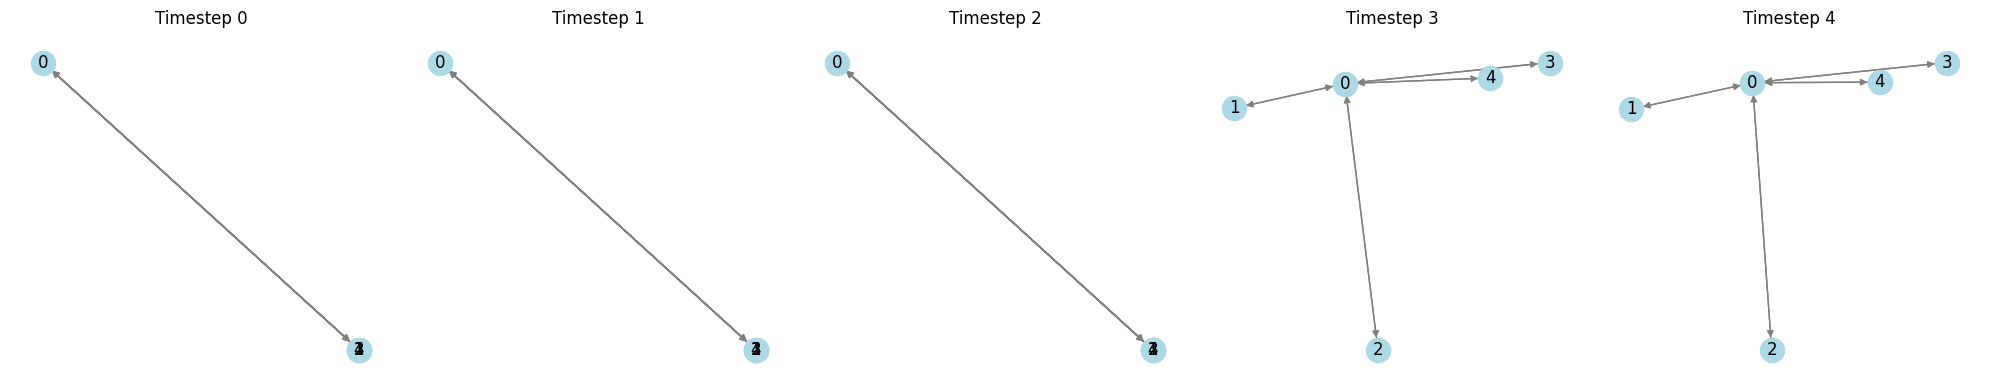

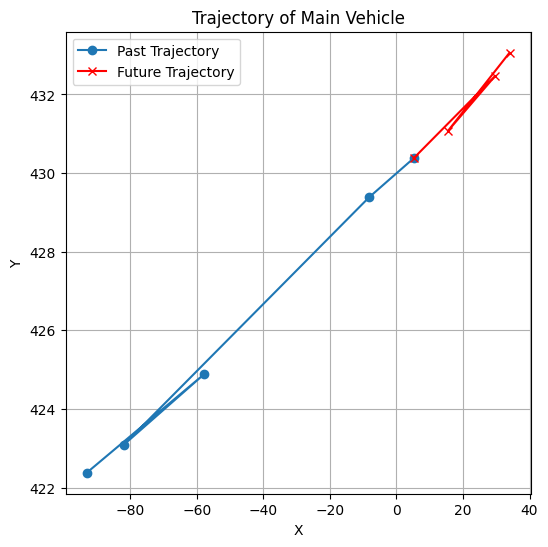

In [52]:
visualize_graph_sequence(*loaded_graph_sequences[61])

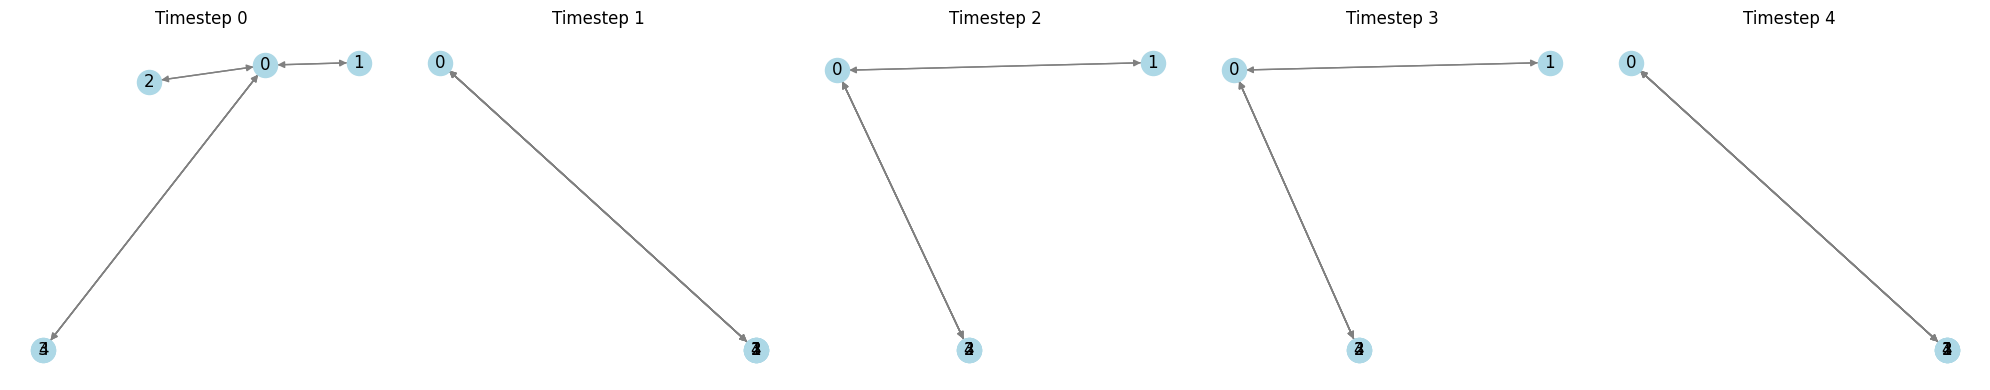

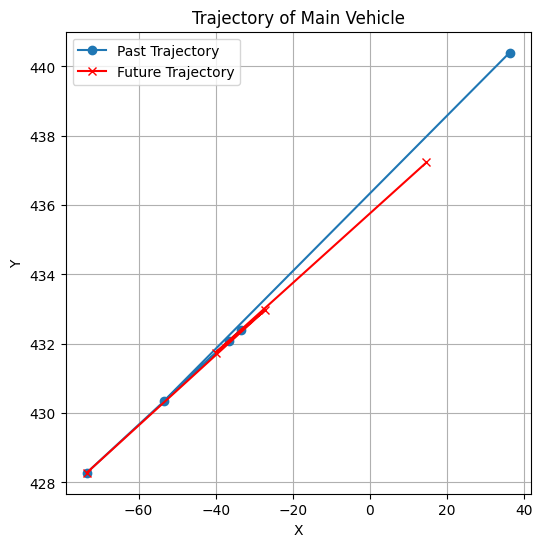

In [55]:
visualize_graph_sequence(*loaded_graph_sequences[63])

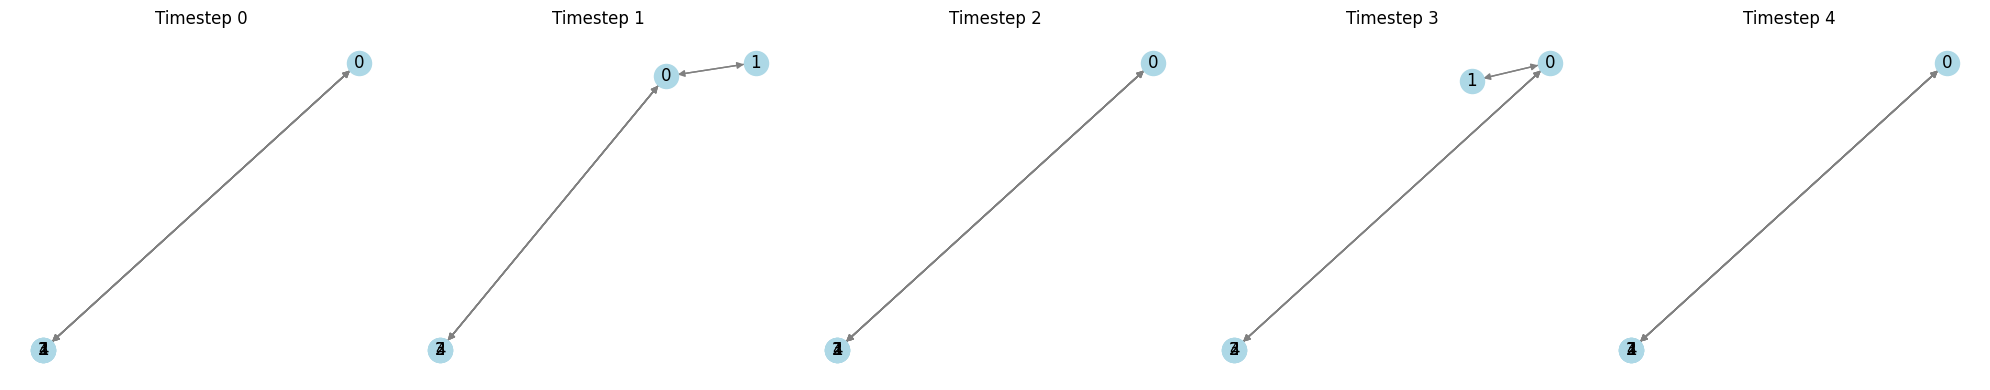

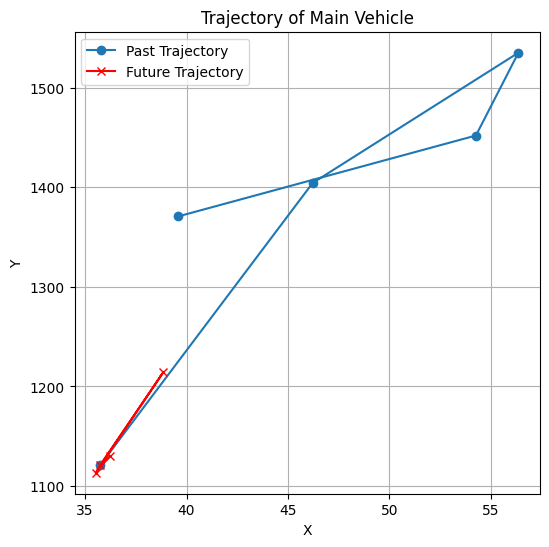

In [57]:
visualize_graph_sequence(*loaded_graph_sequences[172])

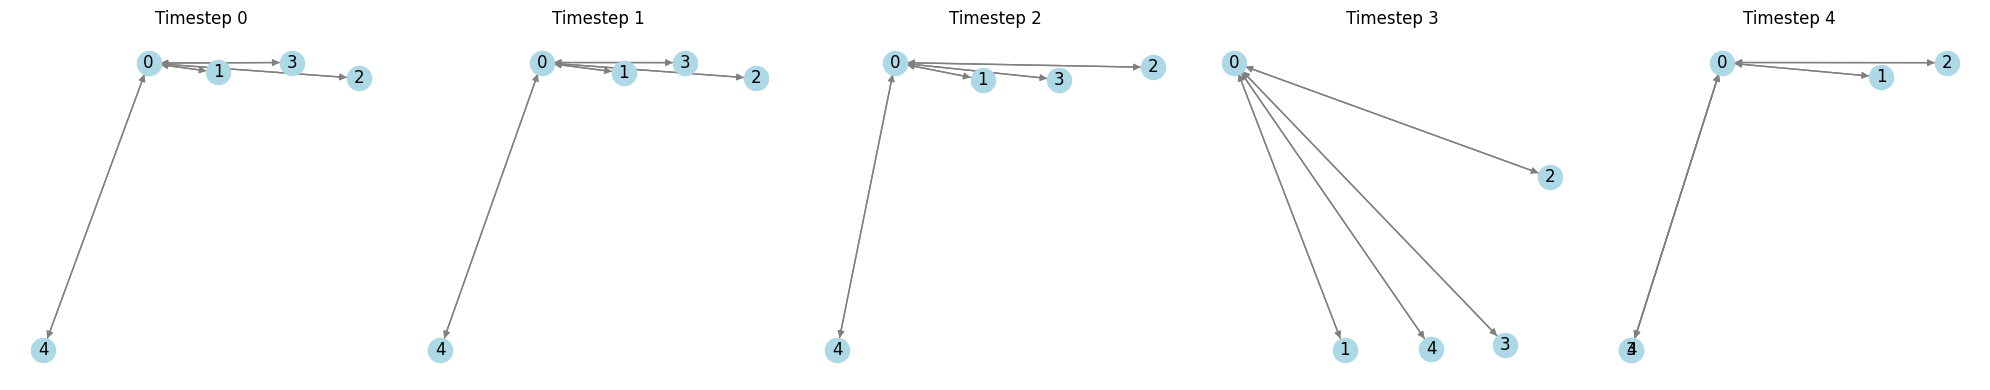

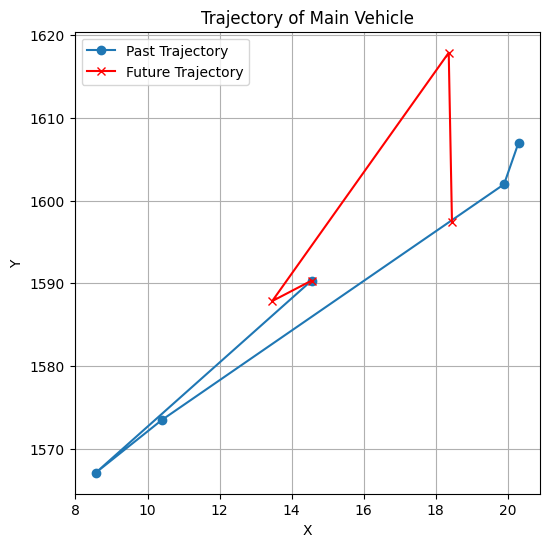

In [60]:
visualize_graph_sequence(*loaded_graph_sequences[97])

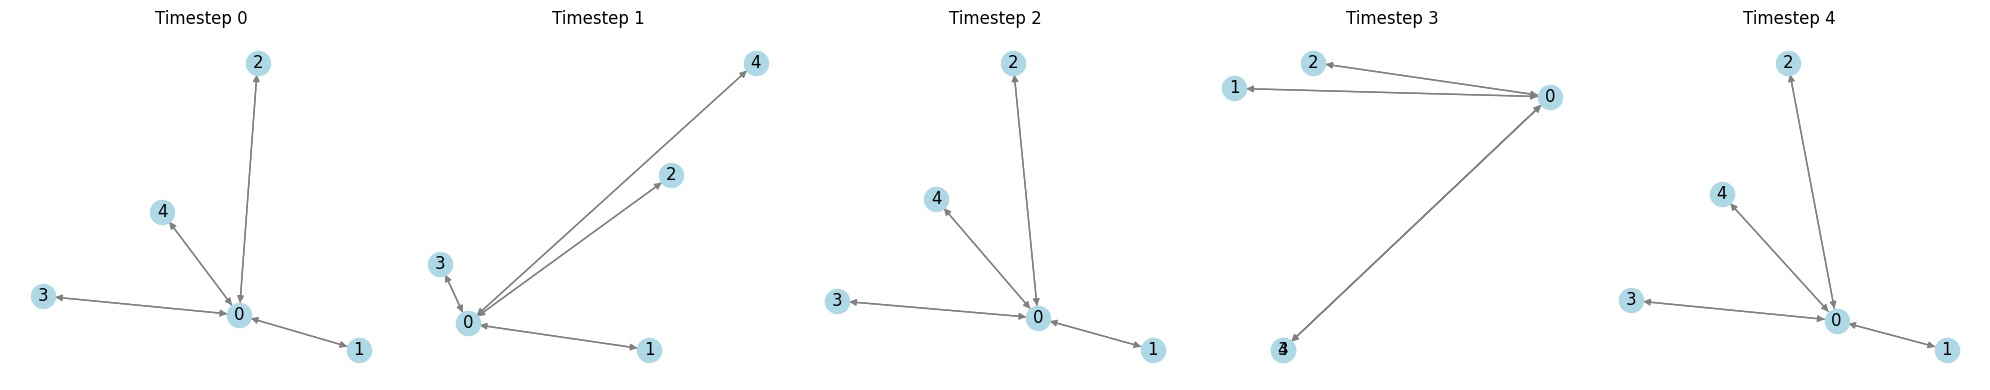

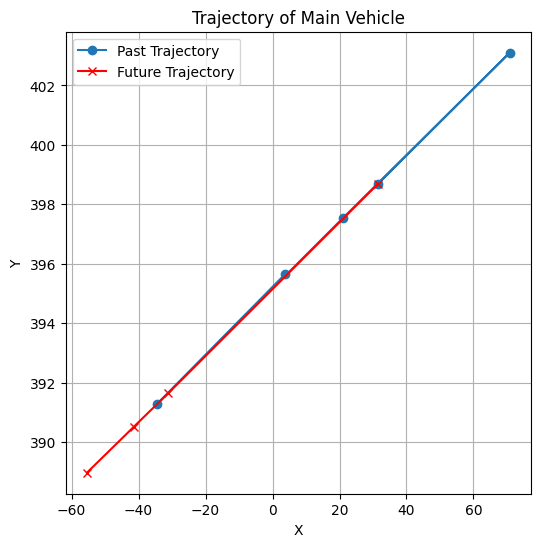

In [63]:
visualize_graph_sequence(*loaded_graph_sequences[27])

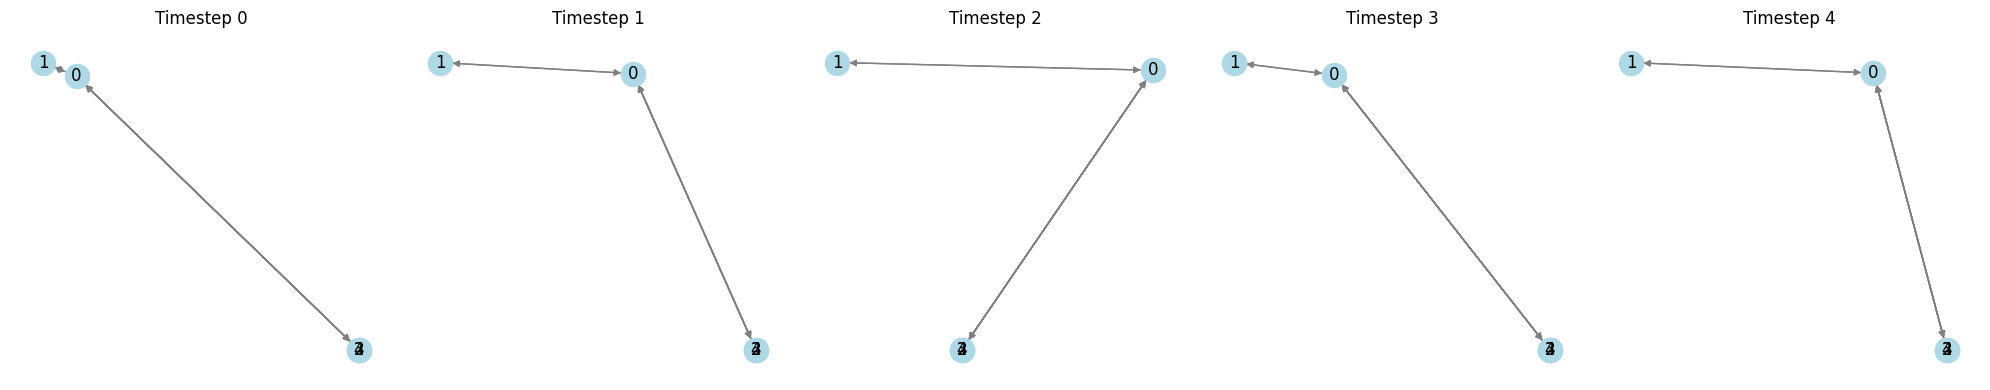

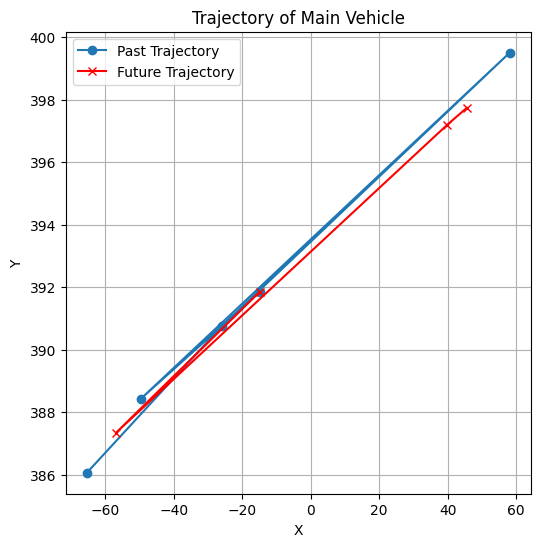

In [69]:
visualize_graph_sequence(*loaded_graph_sequences[109])

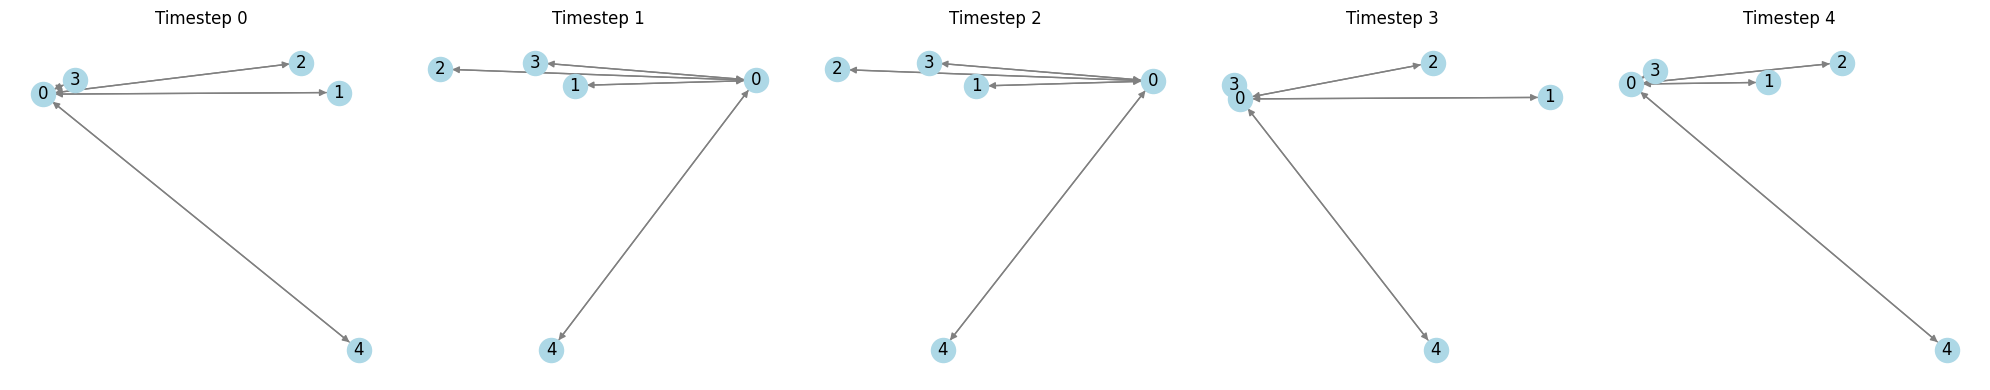

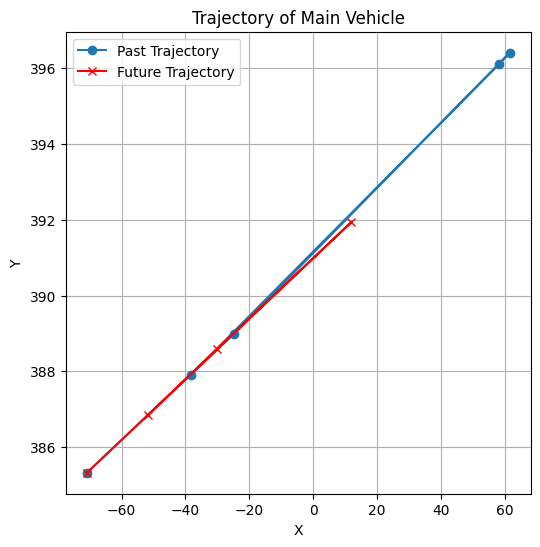

In [78]:
visualize_graph_sequence(*loaded_graph_sequences[98])